# Моделирование цены на квартиру с помощью данных ЦИАНа 

In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression as LR
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error as mae, mean_squared_error as mse

from pylightgbm.models import GBMRegressor
import os
os.environ['LIGHTGBM_EXEC'] = '/home/v0lkoff/LightGBM/lightgbm'

# for plotting, 
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.cm import rainbow
import seaborn as sns #for heatmap
plt.style.use('ggplot')

In [2]:
data = pd.read_csv('Flats_handled.csv', index_col=0)
data.head()

,Bal,Brick,Dist,Floor,Kitsp,Livesp,Metrdist,New,Nfloors,Price,Rooms,Tel,Totsp,Walk,lat,lon
0,True,False,0.041516,3,12.1,66.8,2,False,7,93000000,3,False,142.0,True,55.750038,37.578460
1,True,False,0.020539,7,16.0,116.0,8,False,7,62234214,4,True,172.0,True,55.773024,37.612829
2,False,False,0.026355,3,20.0,86.8,9,False,7,81280000,3,True,146.3,True,55.744024,37.644324
3,False,True,0.057014,2,5.0,12.8,5,False,5,4814581,1,False,17.3,True,55.776294,37.672163
4,False,False,0.057014,2,4.0,17.3,5,False,6,4814581,1,False,17.3,True,55.776294,37.672163


## Visual analysis 

In [3]:
plot_space=['Kitsp', 'Livesp', 'Rooms', 'Totsp']
plot_location=['Dist', 'Metrdist', 'lat', 'lon']
plot_type =['Bal', 'Brick', 'Floor', 'New', 'Nfloors', 'Tel']

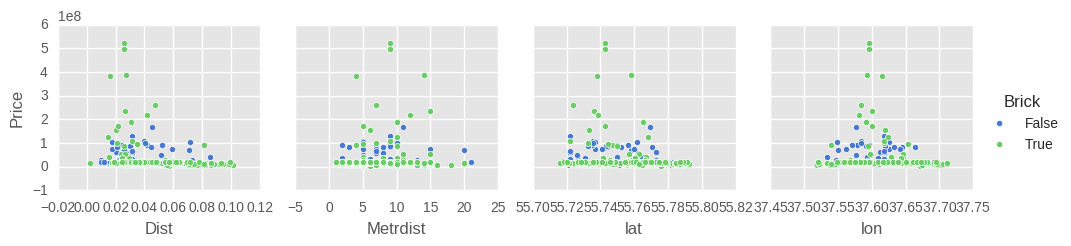

In [4]:
sns.pairplot(data, hue="Brick", x_vars=plot_location, y_vars=['Price'], palette='muted')
plt.savefig('LocationAnalysis.png', dpi=100)

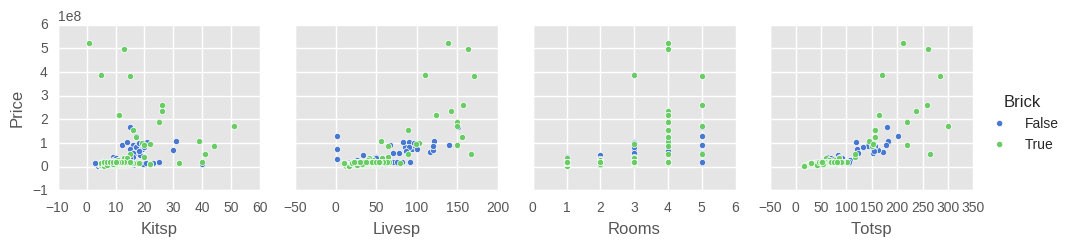

In [5]:
sns.pairplot(data, hue='Brick', x_vars=plot_space, y_vars='Price', palette='muted')
plt.savefig('SpaceAnalysis.png', dpi=100)

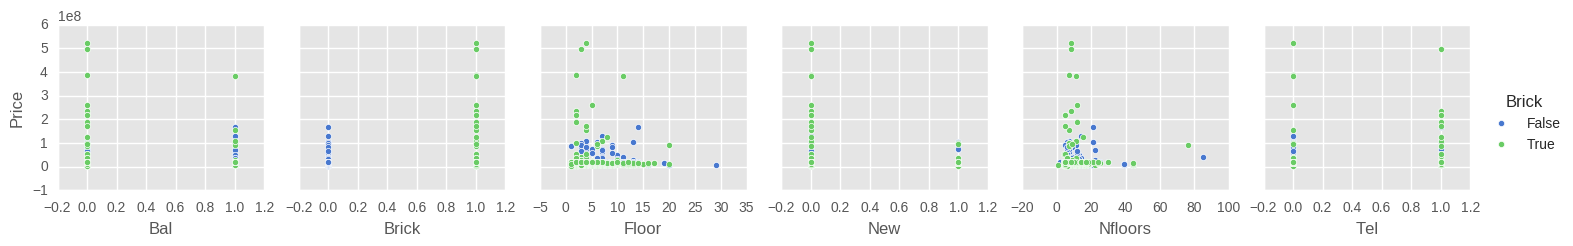

In [6]:
sns.pairplot(data, hue='Brick', x_vars=plot_type, y_vars='Price', palette='muted')
plt.savefig('TypeAnalysis.png', dpi=100)

 Судя по данным все довольно логично. Самые дорогие квартиры в районе пятого этажа, в старых, малоэтажных (до 10 этажей) кирпичных домах. Жилая площадь, общая площадь и число комнат заметно влияют на цену. Особенностью является только то что площадь кухни на цену не влияет. Наверно в самых дорогих квартирах есть гостинные.

### Prepeare for learning

In [7]:
feature_list = data.drop(labels=['Price'], axis=1).columns.tolist()

In [8]:
Xtr, Xval, ytr, yval = train_test_split(
    data[feature_list], data.Price,
    random_state=9, test_size=0.2)

In [9]:
Xtr = np.asarray(Xtr)
Xval = np.asarray(Xval)
ytr = np.asarray(ytr)
yval = np.asarray(yval)

## LightGBM model

In [10]:
gbm = GBMRegressor(
    application='regression',
    tree_learner='serial',
    num_iterations=1000,
    learning_rate=0.01,
    num_leaves=10,
    num_threads=2,
    min_data_in_leaf=12,
    metric='l2',
    feature_fraction=0.8,
    feature_fraction_seed=9,
    bagging_fraction=0.8,
    bagging_freq=1000,
    bagging_seed=93,
    metric_freq=1,
    early_stopping_round=50,
    verbose = 0
)

In [11]:
gbm.fit(Xtr, ytr, test_data=[(Xval, yval)])

In [12]:
ypred = gbm.predict(Xval)
print("Mean Square Error: ", mse(ypred, yval))
print("Best round: ", gbm.best_round)

Mean Square Error:  3.1239613171e+14
Best round:  793


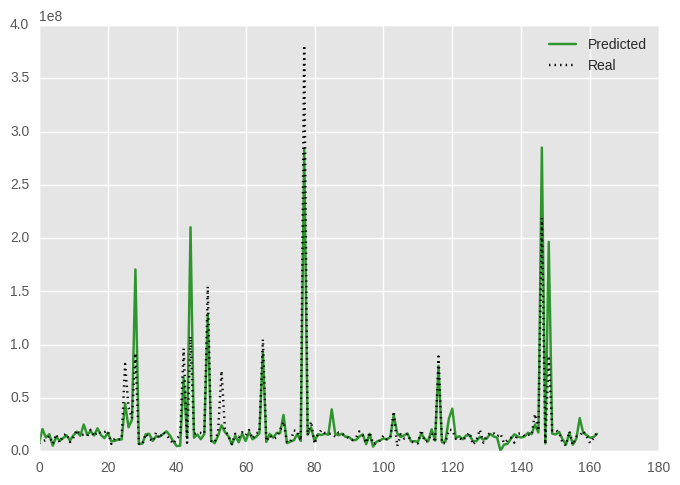

In [13]:
pr, = plt.plot(range(len(ypred)), ypred, c='g', alpha=0.8)
real, = plt.plot(range(len(ypred)), yval, 'k:')
plt.legend([pr, real], ['Predicted', 'Real']);

In [14]:
gbm.score(Xval, yval)

0.78757997863611873

In [15]:
gbm.feature_importance()

{0: 14,
 1: 104,
 2: 659,
 3: 213,
 4: 1256,
 5: 1134,
 6: 290,
 7: 77,
 8: 352,
 9: 202,
 10: 76,
 11: 1670,
 13: 636,
 14: 454}

Прогоноз в целом достаточно точен, однако не понятно, почему из фичей куда-то пропадает указатель, на транспорте можно добраться до метро или пешком (колонка № 12). Кажется, с этим ничего не сделать, поэтому строим важность показателей как есть.

In [16]:
gbm_fetures = feature_list[:12] + feature_list[13:]
feature_imp = pd.DataFrame({'feature': gbm_fetures, 'importance': list(gbm.feature_importance().values())})
feature_imp.sort_values('importance', ascending=1, inplace=1)

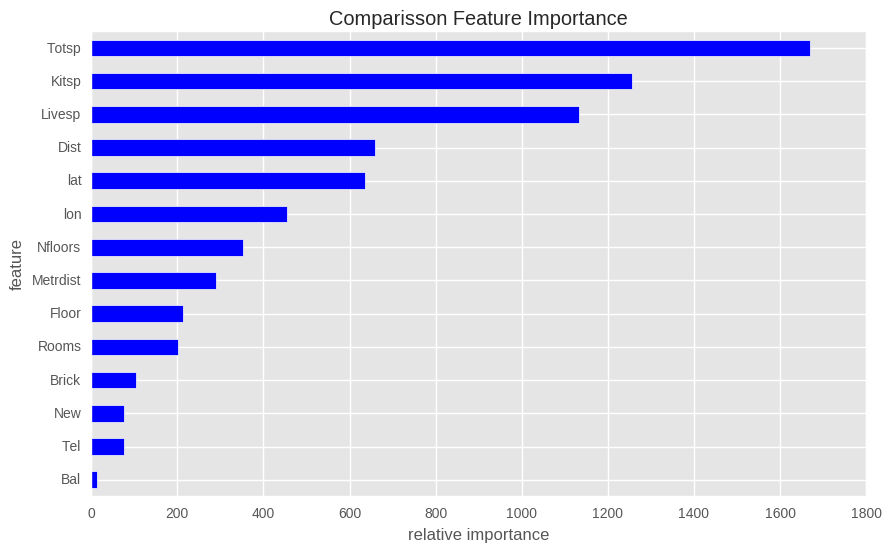

In [17]:
top = 10

plt.figure()
feature_imp.plot(kind='barh',
                     x='feature',
                     y='importance',
                     sort_columns=True,
                     legend=False,
                     figsize=(10, 6),
                     facecolor='Blue',
                     edgecolor='white')
plt.title('Comparisson Feature Importance')
plt.xlabel('relative importance');

В целом прогноз выглядит очень логичным. Как и следовало из графиков на цену квартиры наибольшее влияние оказывает ее площадь, далее следует расположение и удаленность от центра и только затем характеристики дома. Неожиданным пожалуй является только относительная незначимость "кирпичности". 